# Training model on individual transcript parts

Check if training a model only a single transcript part echoes the findings from transcript part ablation

In [1]:
import os
import sys
import shutil
import random
import glob
import multiprocessing
import socket
import pickle
import importlib
import itertools
import functools
import collections
import logging
logging.basicConfig(level=logging.INFO)

import tqdm

import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from statsmodels.stats.multitest import multipletests

from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

SRC_DIR = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'rnafinder')
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import data_loader
import model_utils
import plotting_utils
import kmer
import pwm
import fasta
import interpretation

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots")
assert os.path.isdir(PLOT_DIR)

INTERMEDIATE_DATA_DIR = os.path.join(os.path.dirname(SRC_DIR), "data", "intermediate")
assert os.path.isdir(INTERMEDIATE_DATA_DIR)

np.random.seed(27492)
SEED = 27492

INFO:root:CPU


In [2]:
importlib.reload(data_loader)
K_FOLD = 5
train_dataset = data_loader.LocalizationClassificationKmers("train", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
valid_dataset = data_loader.LocalizationClassificationKmers("valid", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
test_dataset = data_loader.LocalizationClassificationKmers("test", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
train_data = data_loader.load_data_as_np(train_dataset)
valid_data = data_loader.load_data_as_np(valid_dataset)
test_data = data_loader.load_data_as_np(test_dataset)

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 986/2928 = 0.33674863387978143 positive
INFO:root:Lma - 614/2928 = 0.20969945355191258 positive
INFO:root:Mito - 244/2928 = 0.08333333333333333 positive
INFO:root:Nes - 162/2928 = 0.055327868852459015 positive
INFO:root:Nik - 1094/2928 = 0.37363387978142076 positive
INFO:root:Nls - 659/2928 = 0.22506830601092895 positive
INFO:root:NucPore - 129/2928 = 0.04405737704918033 positive
INFO:root:Omm - 582/2928 = 0.1987704918032787 positive
INFO:root:2597	0.8869535519125683	protein_coding
INFO:root:77	0.026297814207650275	lincRNA
INFO:root:77	0.026297814207650275	antisense_RNA
INFO:root:40	0.01366120218579235	processed_pseudogene
INFO:root:36	0.012295081967213115	transcribed_unprocessed_pseudogene
INFO:root:24	0.00819672131147541	processed_transcript


Validation AUROC: 0.7467255385060354
Validation AUPRC: 0.4103248524326642


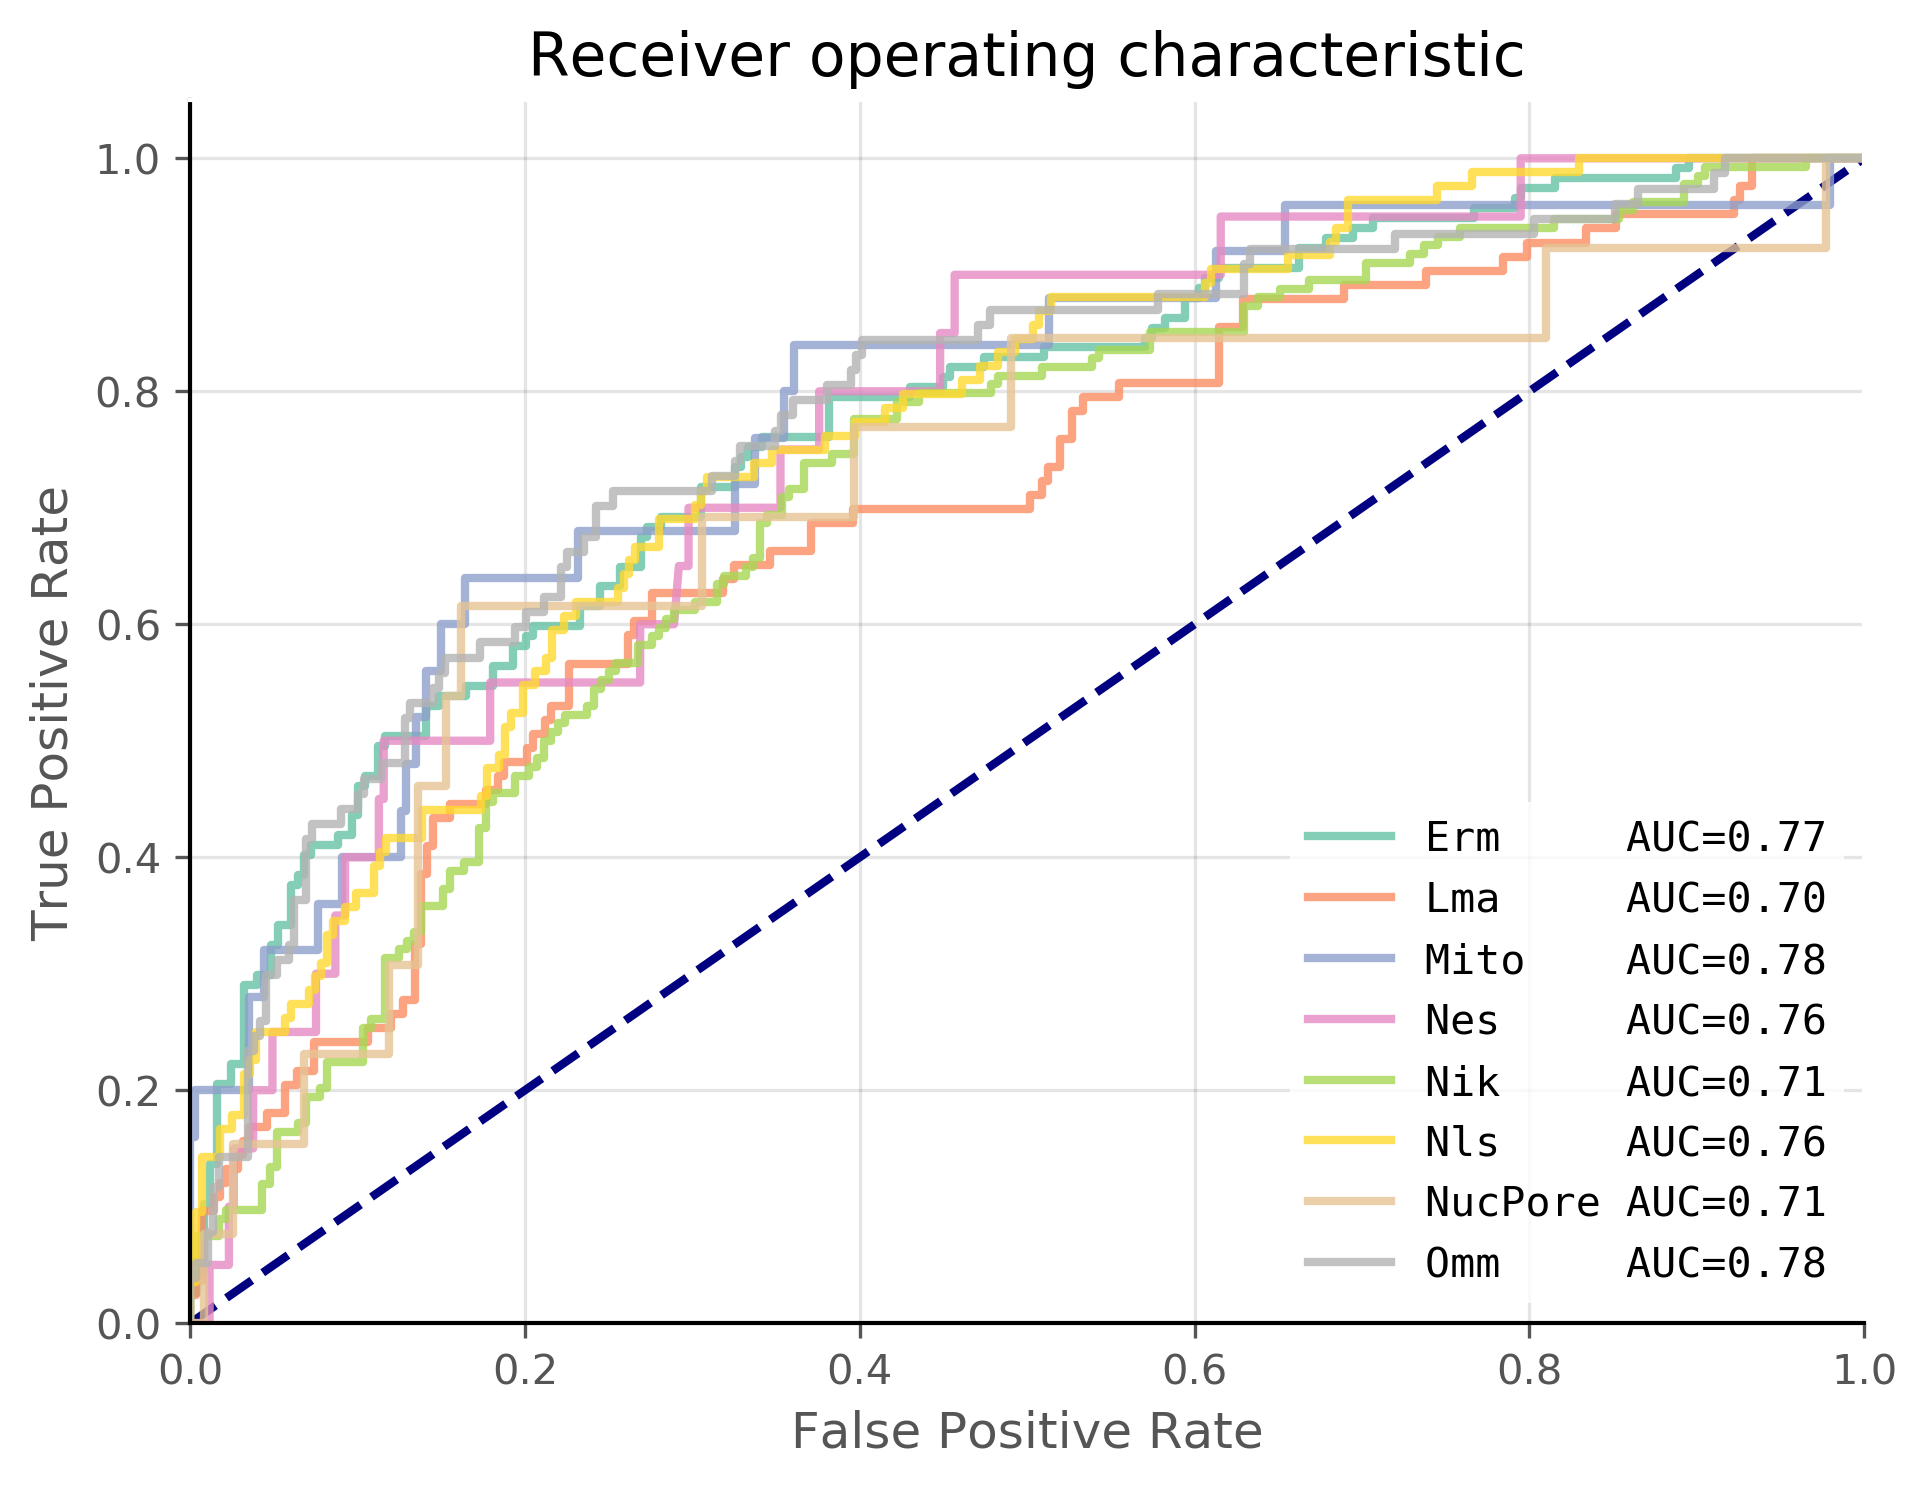

In [3]:
# Random forest classifier
rf_kwargs = {
    'n_estimators': 300,
    'criterion': 'entropy',
    'max_depth': 100,
    'min_samples_leaf': 0.001,
    'max_features': 'sqrt',
    'class_weight': None,
    'n_jobs': 32,
    'random_state': 39282,
}

rf_model, rf_per_class_perf, rf_overall_perf = model_utils.multi_train(
    RandomForestClassifier(**rf_kwargs),
    train_data,
    valid_data,
    verbose=False
)
print("Validation AUROC: {}".format(rf_overall_perf.auroc))
print("Validation AUPRC: {}".format(rf_overall_perf.auprc))
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(train_dataset.compartments, rf_per_class_perf)}
)

In [4]:
# Test set
rf_test_overall_perf = model_utils.generate_model_perf(
    truths=test_data[1],
    pred_probs=model_utils.list_preds_to_array_preds(rf_model.predict_proba(test_data[0])),
    multiclass=True,
)
print(rf_test_overall_perf.auroc, rf_test_overall_perf.auprc)

0.7678688021252544 0.49441421899593996


## 5' UTR only

In [5]:
importlib.reload(data_loader)
train_dataset_5utr = data_loader.LocalizationClassificationKmers("train", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['u5'], addtl_negatives=False)
valid_dataset_5utr = data_loader.LocalizationClassificationKmers("valid", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['u5'], addtl_negatives=False)
test_dataset_5utr = data_loader.LocalizationClassificationKmers("test", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['u5'], addtl_negatives=False)
train_data_5utr = data_loader.load_data_as_np(train_dataset_5utr)
valid_data_5utr = data_loader.load_data_as_np(valid_dataset_5utr)
test_data_5utr = data_loader.load_data_as_np(test_dataset_5utr)

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 986/2928 = 0.33674863387978143 positive
INFO:root:Lma - 614/2928 = 0.20969945355191258 positive
INFO:root:Mito - 244/2928 = 0.08333333333333333 positive
INFO:root:Nes - 162/2928 = 0.055327868852459015 positive
INFO:root:Nik - 1094/2928 = 0.37363387978142076 positive
INFO:root:Nls - 659/2928 = 0.22506830601092895 positive
INFO:root:NucPore - 129/2928 = 0.04405737704918033 positive
INFO:root:Omm - 582/2928 = 0.1987704918032787 positive
INFO:root:2597	0.8869535519125683	protein_coding
INFO:root:77	0.026297814207650275	lincRNA
INFO:root:77	0.026297814207650275	antisense_RNA
INFO:root:40	0.01366120218579235	processed_pseudogene
INFO:root:36	0.012295081967213115	transcribed_unprocessed_pseudogene
INFO:root:24	0.00819672131147541	processed_transcript


In [6]:
train_data_5utr[0].shape

(2928, 1344)

Validation AUROC: 0.5859726238747034
Validation AUPRC: 0.27427176738529147


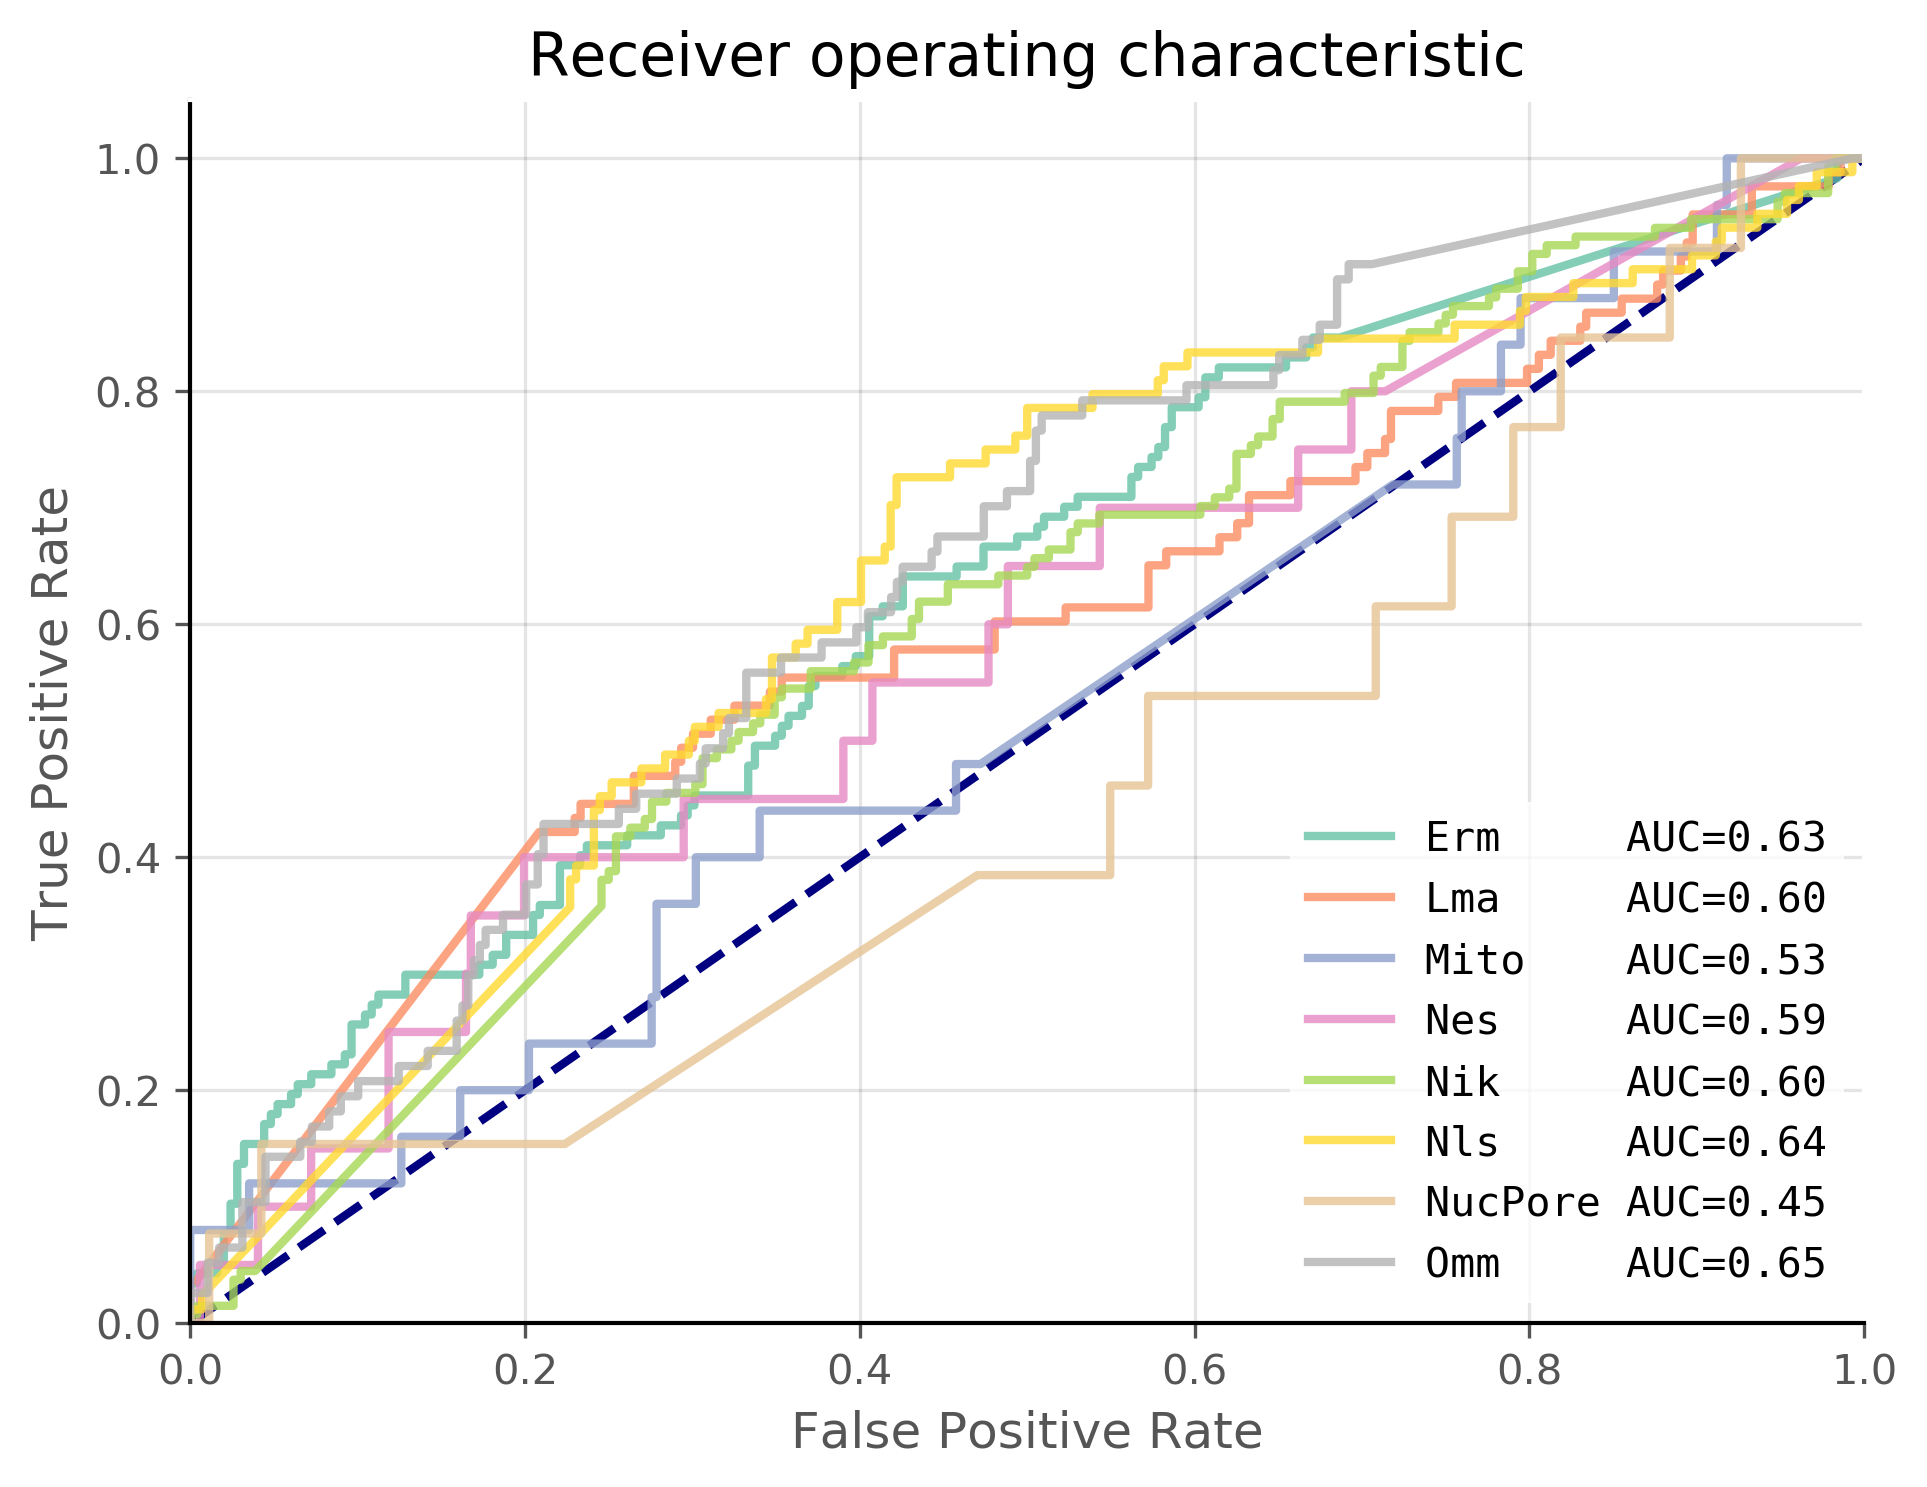

In [7]:
rf_model_5utr, rf_per_class_perf_5utr, rf_overall_perf_5utr = model_utils.multi_train(
    RandomForestClassifier(**rf_kwargs),
    train_data_5utr,
    valid_data_5utr,
    verbose=False
)
print("Validation AUROC: {}".format(rf_overall_perf_5utr.auroc))
print("Validation AUPRC: {}".format(rf_overall_perf_5utr.auprc))
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(train_dataset_5utr.compartments, rf_per_class_perf_5utr)}
)

In [8]:
# Test set
rf_test_overall_5utr_perf = model_utils.generate_model_perf(
    truths=test_data_5utr[1],
    pred_probs=model_utils.list_preds_to_array_preds(rf_model_5utr.predict_proba(test_data_5utr[0])),
    multiclass=True,
)
print(rf_test_overall_5utr_perf.auroc, rf_test_overall_5utr_perf.auprc)

0.6120314296108651 0.2986936144267218


## CDS only

In [9]:
importlib.reload(data_loader)
train_dataset_cds = data_loader.LocalizationClassificationKmers("train", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['cds'], addtl_negatives=False)
valid_dataset_cds = data_loader.LocalizationClassificationKmers("valid", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['cds'], addtl_negatives=False)
test_dataset_cds = data_loader.LocalizationClassificationKmers("test", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['cds'], addtl_negatives=False)
train_data_cds = data_loader.load_data_as_np(train_dataset_cds)
valid_data_cds = data_loader.load_data_as_np(valid_dataset_cds)
test_data_cds = data_loader.load_data_as_np(test_dataset_cds)

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 986/2928 = 0.33674863387978143 positive
INFO:root:Lma - 614/2928 = 0.20969945355191258 positive
INFO:root:Mito - 244/2928 = 0.08333333333333333 positive
INFO:root:Nes - 162/2928 = 0.055327868852459015 positive
INFO:root:Nik - 1094/2928 = 0.37363387978142076 positive
INFO:root:Nls - 659/2928 = 0.22506830601092895 positive
INFO:root:NucPore - 129/2928 = 0.04405737704918033 positive
INFO:root:Omm - 582/2928 = 0.1987704918032787 positive
INFO:root:2597	0.8869535519125683	protein_coding
INFO:root:77	0.026297814207650275	lincRNA
INFO:root:77	0.026297814207650275	antisense_RNA
INFO:root:40	0.01366120218579235	processed_pseudogene
INFO:root:36	0.012295081967213115	transcribed_unprocessed_pseudogene
INFO:root:24	0.00819672131147541	processed_transcript


In [10]:
train_data_cds[0].shape

(2928, 1344)

Validation AUROC: 0.7241616205371567
Validation AUPRC: 0.3749817065846438


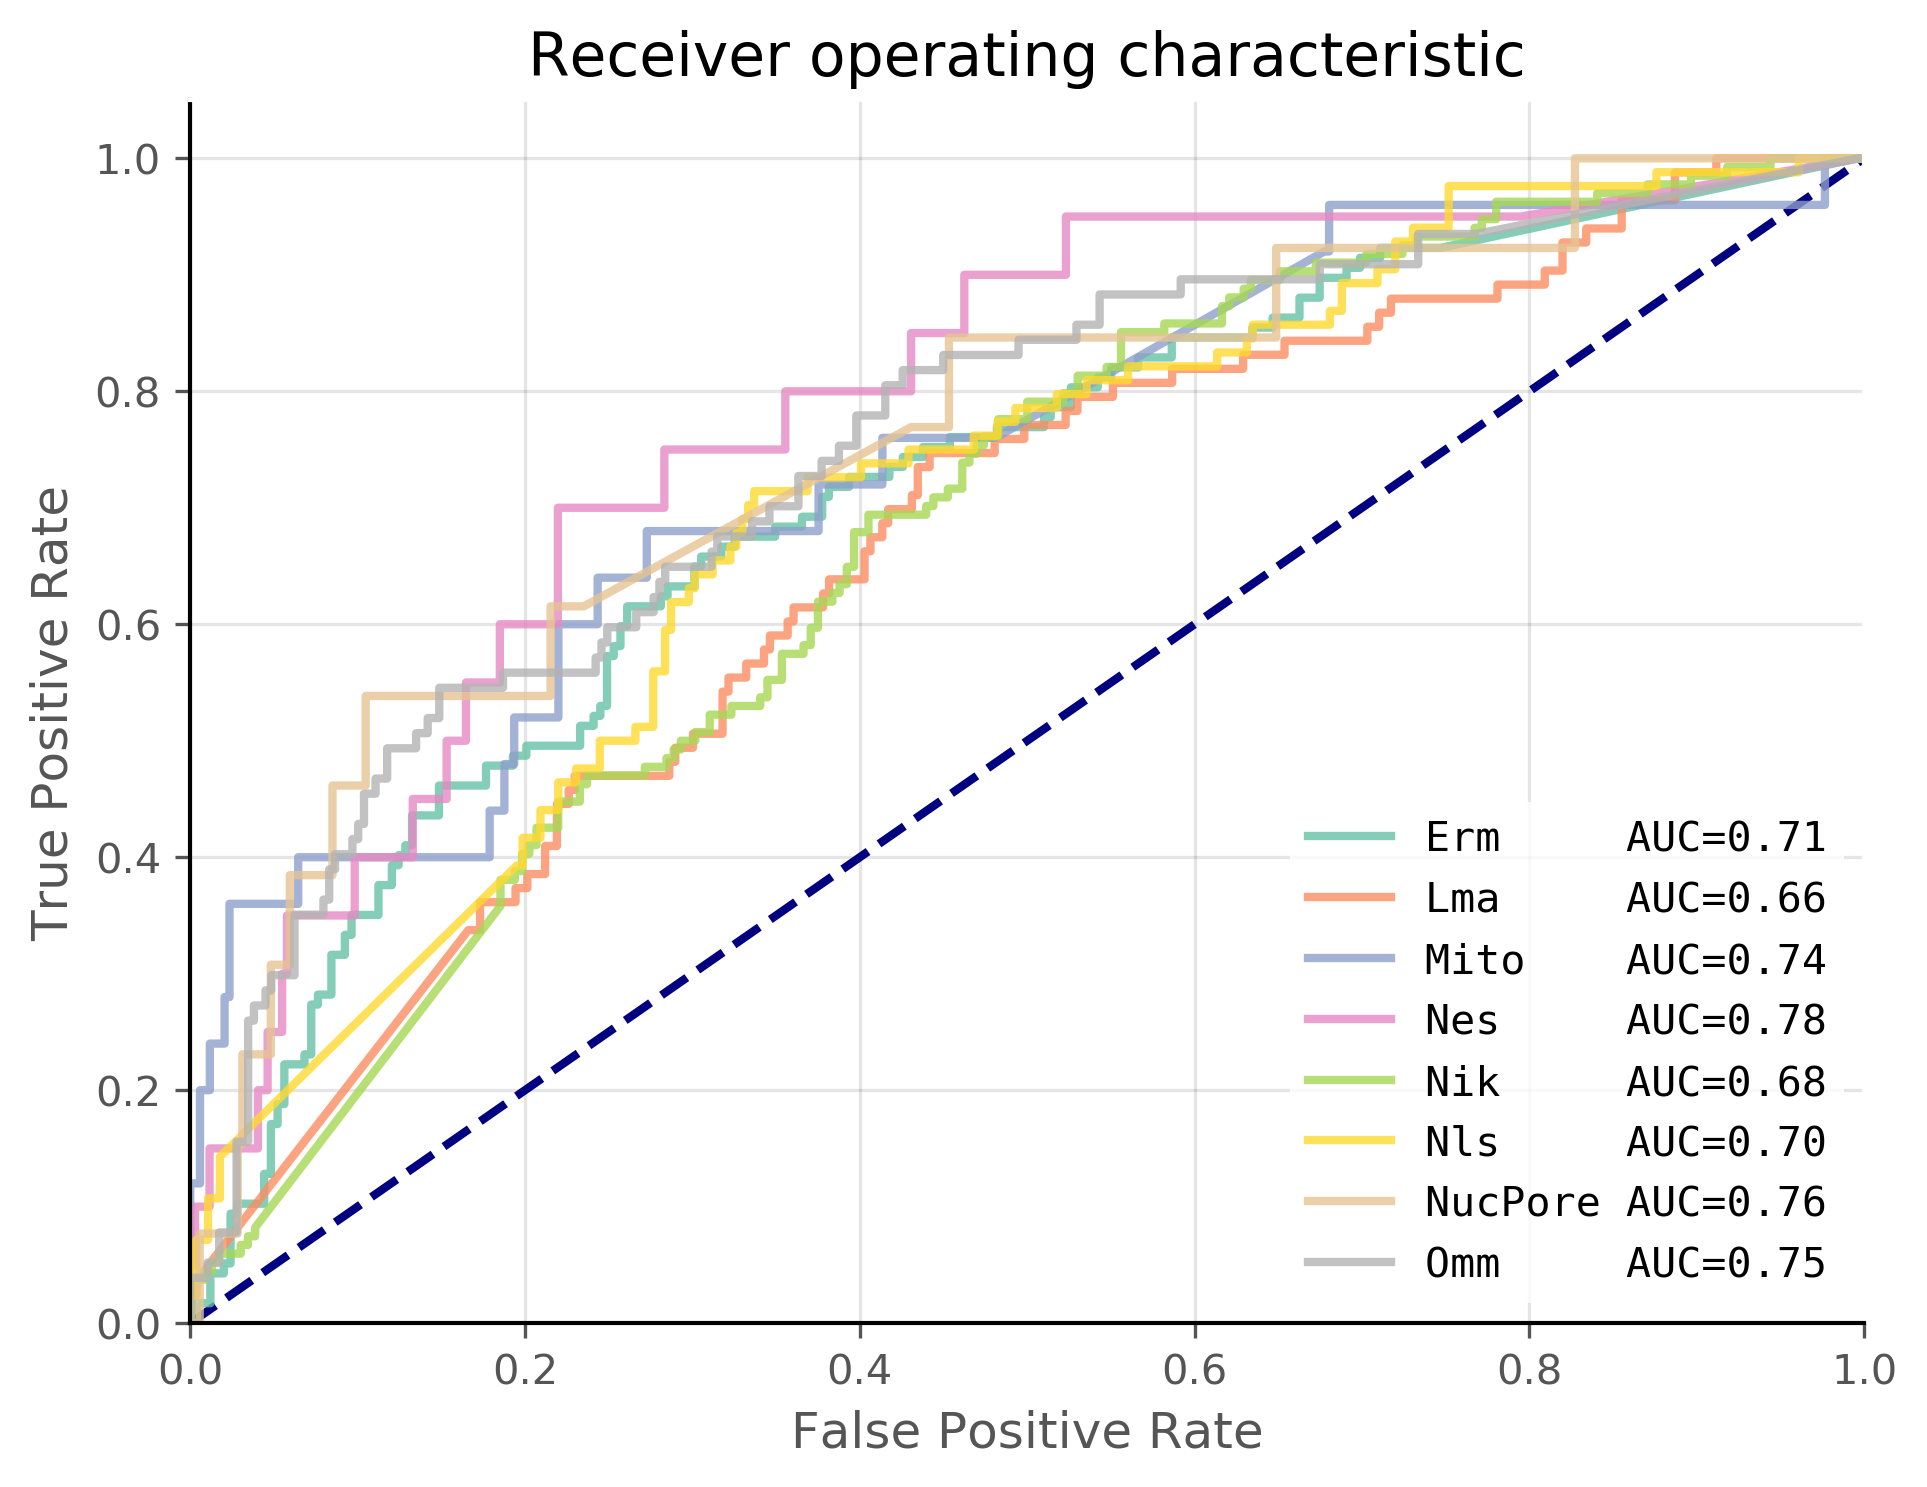

In [11]:
rf_model_cds, rf_per_class_perf_cds, rf_overall_perf_cds = model_utils.multi_train(
    RandomForestClassifier(**rf_kwargs),
    train_data_cds,
    valid_data_cds,
    verbose=False
)
print("Validation AUROC: {}".format(rf_overall_perf_cds.auroc))
print("Validation AUPRC: {}".format(rf_overall_perf_cds.auprc))
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(train_dataset_cds.compartments, rf_per_class_perf_cds)}
)

In [12]:
# Test set
rf_test_overall_cds_perf = model_utils.generate_model_perf(
    truths=test_data_cds[1],
    pred_probs=model_utils.list_preds_to_array_preds(rf_model_cds.predict_proba(test_data_cds[0])),
    multiclass=True,
)
print(rf_test_overall_cds_perf.auroc, rf_test_overall_cds_perf.auprc)

0.7407497645474395 0.4210115567593173


## 3' UTR only

In [13]:
importlib.reload(data_loader)
train_dataset_3utr = data_loader.LocalizationClassificationKmers("train", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['u3'], addtl_negatives=False)
valid_dataset_3utr = data_loader.LocalizationClassificationKmers("valid", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['u3'], addtl_negatives=False)
test_dataset_3utr = data_loader.LocalizationClassificationKmers("test", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['u3'], addtl_negatives=False)
train_data_3utr = data_loader.load_data_as_np(train_dataset_3utr)
valid_data_3utr = data_loader.load_data_as_np(valid_dataset_3utr)
test_data_3utr = data_loader.load_data_as_np(test_dataset_3utr)

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 986/2928 = 0.33674863387978143 positive
INFO:root:Lma - 614/2928 = 0.20969945355191258 positive
INFO:root:Mito - 244/2928 = 0.08333333333333333 positive
INFO:root:Nes - 162/2928 = 0.055327868852459015 positive
INFO:root:Nik - 1094/2928 = 0.37363387978142076 positive
INFO:root:Nls - 659/2928 = 0.22506830601092895 positive
INFO:root:NucPore - 129/2928 = 0.04405737704918033 positive
INFO:root:Omm - 582/2928 = 0.1987704918032787 positive
INFO:root:2597	0.8869535519125683	protein_coding
INFO:root:77	0.026297814207650275	lincRNA
INFO:root:77	0.026297814207650275	antisense_RNA
INFO:root:40	0.01366120218579235	processed_pseudogene
INFO:root:36	0.012295081967213115	transcribed_unprocessed_pseudogene
INFO:root:24	0.00819672131147541	processed_transcript


In [14]:
train_data_3utr[0].shape

(2928, 1344)

Validation AUROC: 0.6898121139227372
Validation AUPRC: 0.3527445291486109


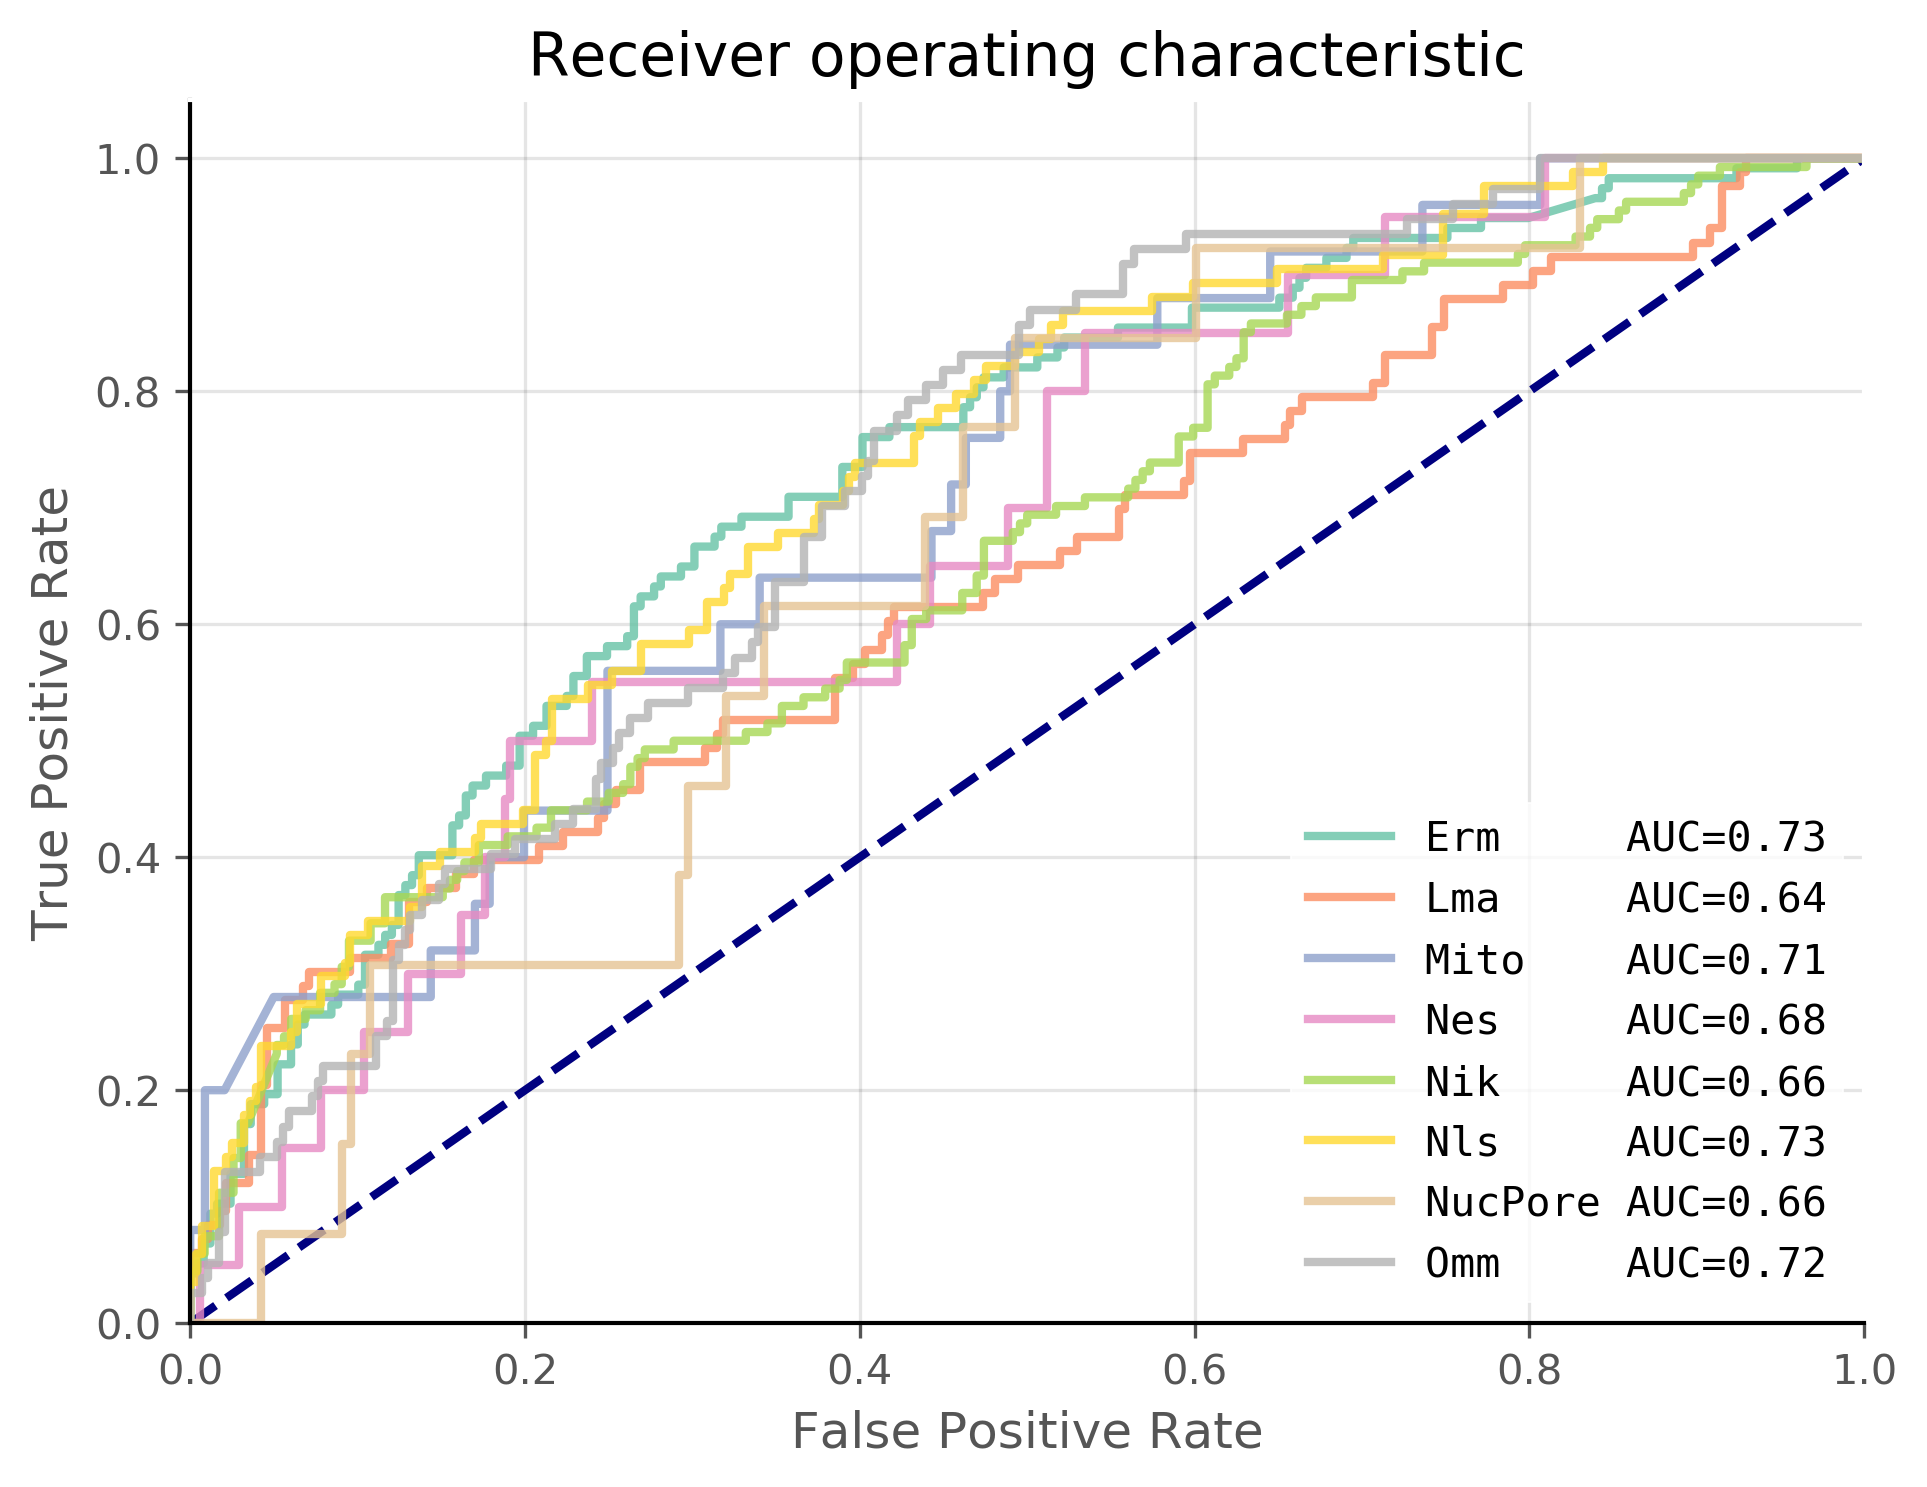

In [15]:
rf_model_3utr, rf_per_class_perf_3utr, rf_overall_perf_3utr = model_utils.multi_train(
    RandomForestClassifier(**rf_kwargs),
    train_data_3utr,
    valid_data_3utr,
    verbose=False
)
print("Validation AUROC: {}".format(rf_overall_perf_3utr.auroc))
print("Validation AUPRC: {}".format(rf_overall_perf_3utr.auprc))
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(train_dataset_3utr.compartments, rf_per_class_perf_3utr)}
)

In [16]:
# Test set
rf_test_overall_3utr_perf = model_utils.generate_model_perf(
    truths=test_data_3utr[1],
    pred_probs=model_utils.list_preds_to_array_preds(rf_model_3utr.predict_proba(test_data_3utr[0])),
    multiclass=True,
)
print(rf_test_overall_3utr_perf.auroc, rf_test_overall_3utr_perf.auprc)

0.7196077039315483 0.4071644697707717


## Summary plot

In [17]:
auroc_df = pd.DataFrame(
    0,
    columns=train_dataset_3utr.compartments,
    index=['Full sequence', "5' UTR", "CDS", "3' UTR"],
)
auprc_df = pd.DataFrame(
    0,
    columns=train_dataset.compartments,
    index=["Full sequence", "5' UTR", "CDS", "3' UTR"],
)

for localization, perf in zip(train_dataset.compartments, rf_per_class_perf):
    auroc_df.loc['Full sequence', localization] = perf.auroc
    auprc_df.loc['Full sequence', localization] = perf.auprc

for localization, perf in zip(train_dataset_5utr.compartments, rf_per_class_perf_5utr):
    auroc_df.loc["5' UTR", localization] = perf.auroc
    auprc_df.loc["5' UTR", localization] = perf.auprc

for localization, perf in zip(train_dataset_cds.compartments, rf_per_class_perf_cds):
    auroc_df.loc['CDS', localization] = perf.auroc
    auprc_df.loc['CDS', localization] = perf.auprc
    
for localization, perf in zip(train_dataset_3utr.compartments, rf_per_class_perf_3utr):
    auroc_df.loc["3' UTR", localization] = perf.auroc
    auprc_df.loc["3' UTR", localization] = perf.auprc

importlib.reload(data_loader)
auroc_df.columns = [data_loader.LOCALIZATION_FULL_NAME_DICT[l] for l in auroc_df.columns]
auprc_df.columns = [data_loader.LOCALIZATION_FULL_NAME_DICT[l] for l in auprc_df.columns]
auroc_df

,ER membrane,Nuclear lamina,Mito matrix,Cytosol,Nucleolus,Nucleus,Nuclear pore,Outer mito membrane
Full sequence,0.771634,0.696113,0.780059,0.764523,0.712944,0.761694,0.708651,0.778187
5' UTR,0.631483,0.595853,0.527859,0.590173,0.600071,0.637285,0.454020,0.651036
CDS,0.714276,0.664098,0.742639,0.783092,0.677078,0.704407,0.755938,0.751764
3' UTR,0.729413,0.636000,0.708270,0.677601,0.659644,0.729061,0.660492,0.718016


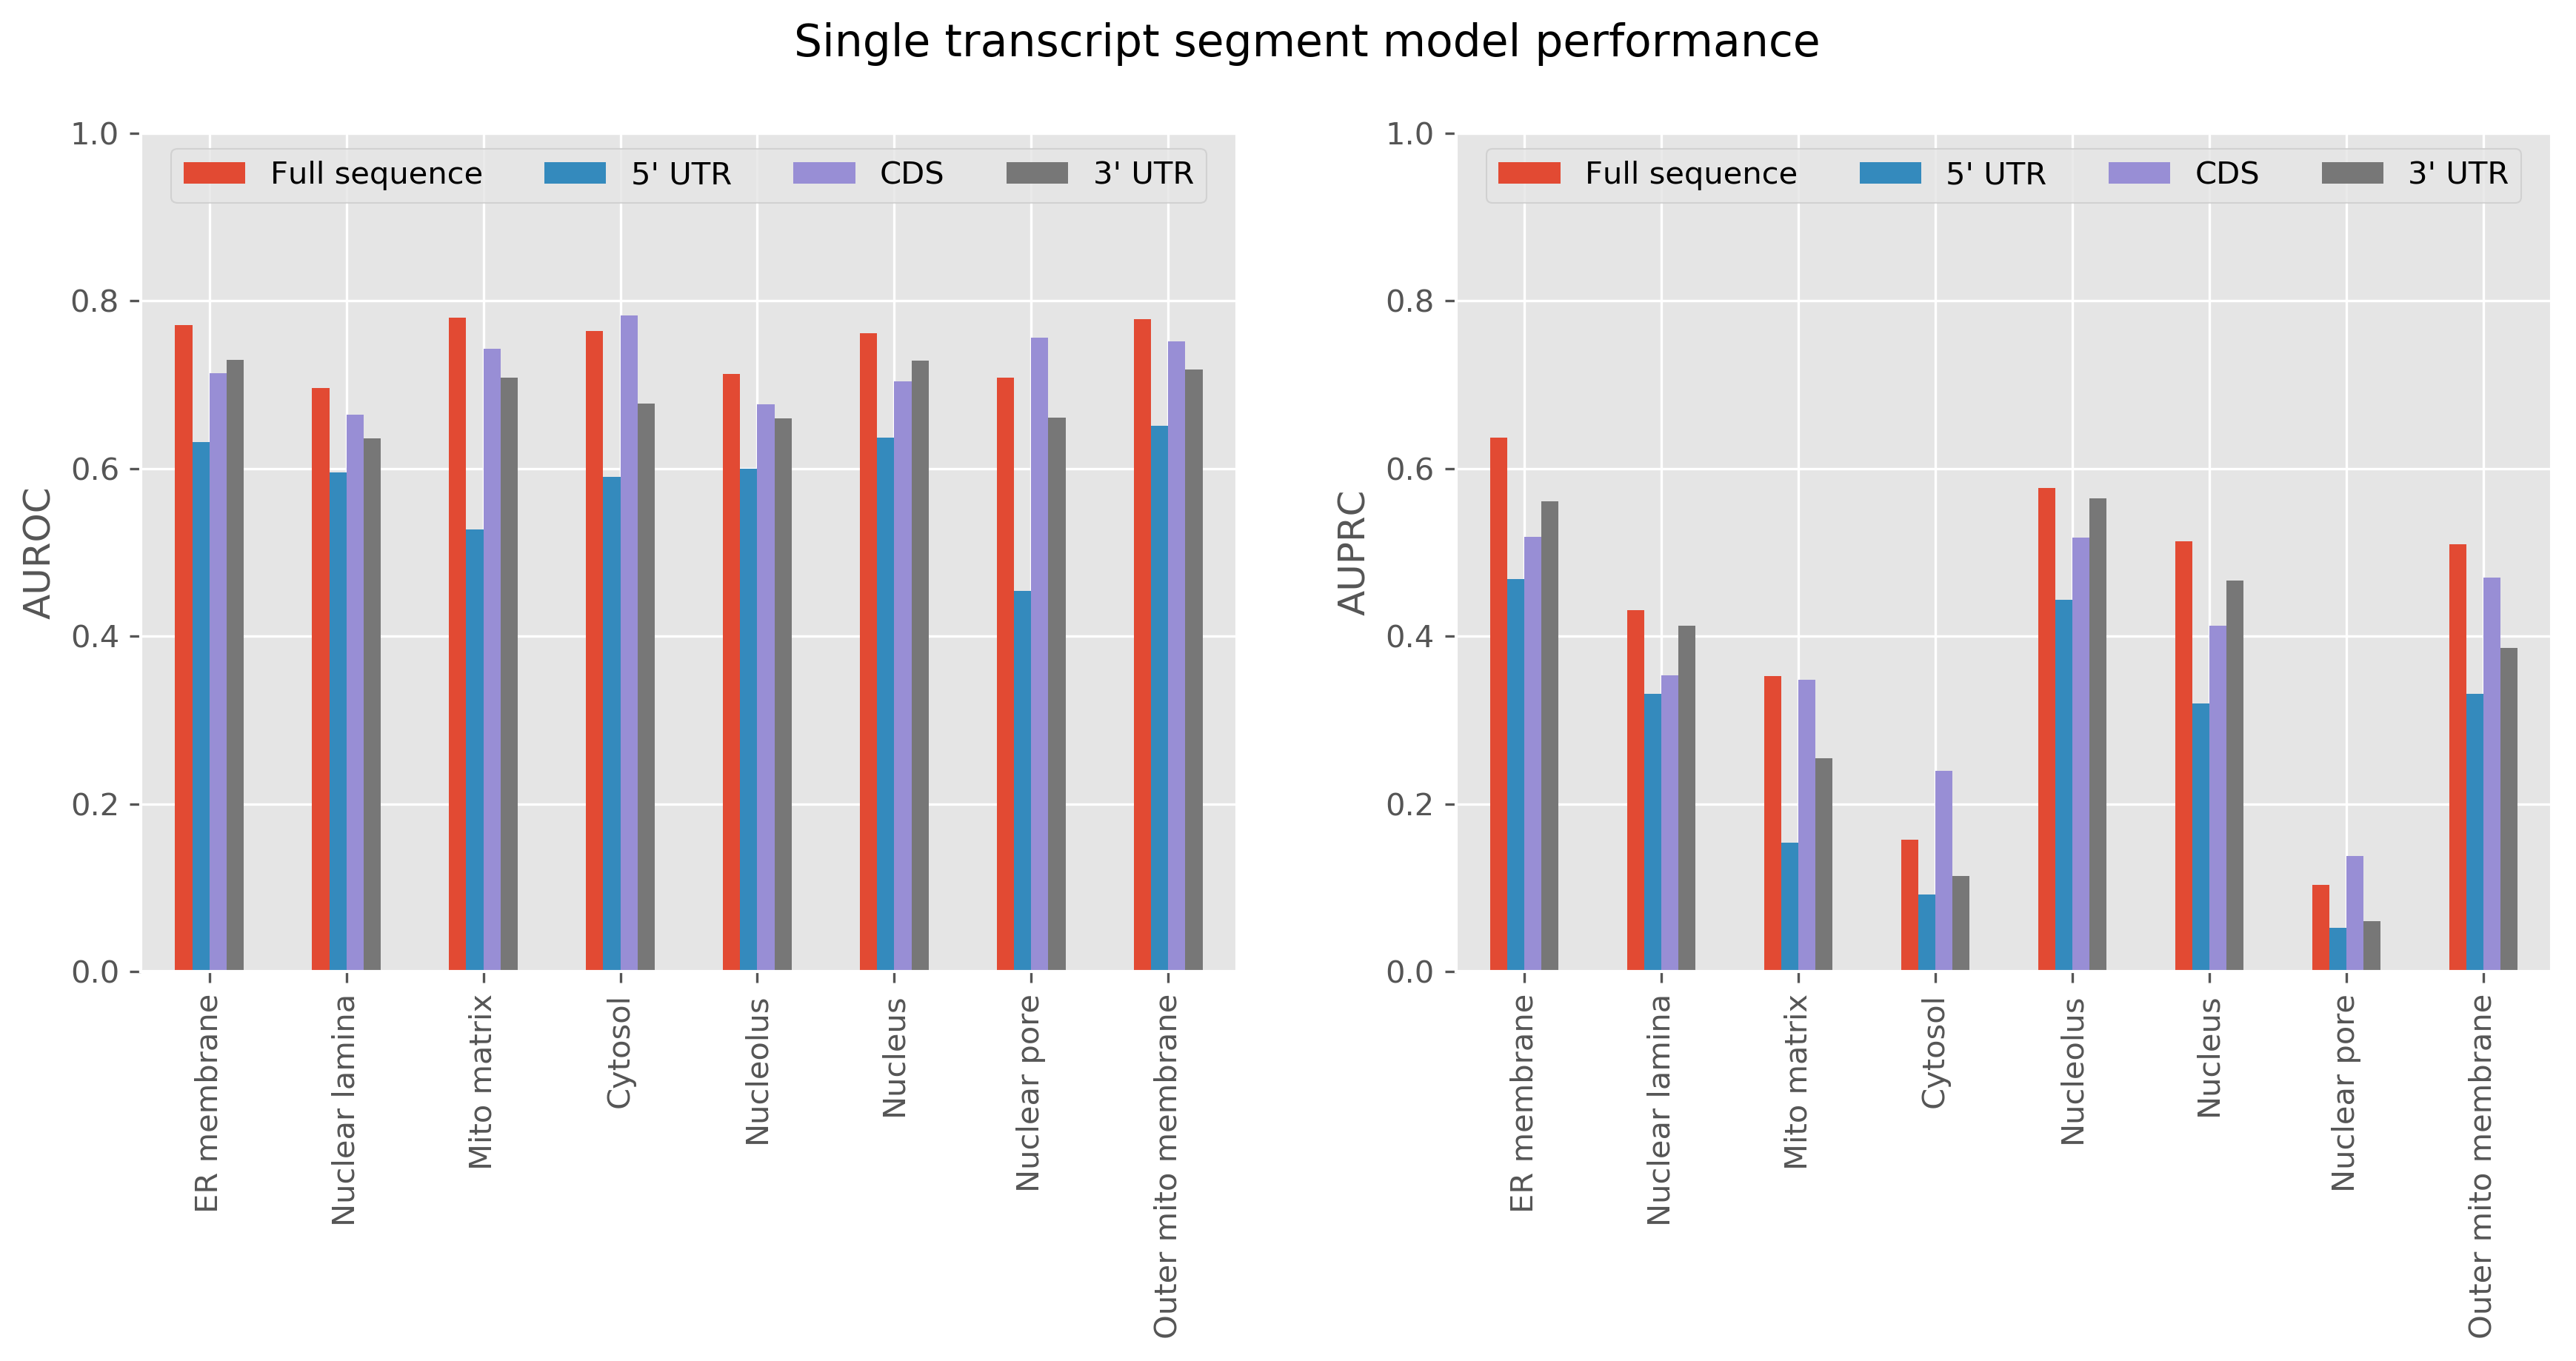

In [18]:
fig, (ax1, ax2) = plt.subplots(dpi=300, ncols=2, figsize=(14, 5))
auroc_df.T.plot.bar(ax=ax1, legend=True)
ax1.set(
#     title="Transcript part ablation performance",
    ylabel="AUROC",
#     facecolor='white',
    ylim=[0, 1],
)
ax1.legend(
    loc='upper center',
    ncol=4,
)

auprc_df.T.plot.bar(ax=ax2, legend=True)
ax2.set(
#     title="Transcript part ablation performance",
    ylabel="AUPRC",
#     facecolor='white',
    ylim=[0, 1],
)
ax2.legend(
    loc='upper center',
    ncol=4,
)
fig.suptitle("Single transcript segment model performance", size='x-large')
fig.show()